In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, PReLU, Input, Reshape, Layer
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np
from astropy.io import fits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d

def build_encoder(input_shape, latent_dim):
    input_layer = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv1D(filters=128, kernel_size=5, padding='valid', name='conv1')(input_layer)
    x = PReLU(name='prelu1')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1')(x)

    x = Conv1D(filters=256, kernel_size=11, padding='valid', name='conv2')(x)
    x = PReLU(name='prelu2')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool2')(x)

    x = Conv1D(filters=512, kernel_size=21, padding='valid', name='conv3')(x)
    x = PReLU(name='prelu3')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool3')(x)

    # Flatten the output from Conv layers
    x = Flatten(name='flatten')(x)

    # Fully Connected Layers
    x = Dense(256, name='dense1')(x)
    x = PReLU(name='prelu4')(x)
    x = Dense(128, name='dense2')(x)
    x = PReLU(name='prelu5')(x)
    x = Dense(64, name='dense3')(x)
    x = PReLU(name='prelu6')(x)

    # Latent Space
    latent_space = Dense(latent_dim, name='latent_space')(x)

    return Model(input_layer, latent_space, name='encoder')

def build_decoder(latent_dim, output_dim):
    latent_input = Input(shape=(latent_dim,))
    
    # Fully Connected Layers to generate rest frame representation
    x = Dense(64)(latent_input)
    x = PReLU()(x)
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dense(1024)(x)
    x = PReLU()(x)
    x = Dense(output_dim)(x)
    output = Reshape((output_dim, 1))(x)

    return Model(latent_input, output, name='decoder')

def build_autoencoder(input_shape, latent_dim):
    spectra_input = Input(shape=input_shape, name='spectra_input')

    encoder = build_encoder(input_shape, latent_dim)
    latent_space = encoder(spectra_input)
    
    decoder = build_decoder(latent_dim, input_shape[0])
    reconstructed_output = decoder(latent_space)

    return Model(spectra_input, outputs=reconstructed_output, name='autoencoder')

In [7]:
data_dir = '/Users/tkiker/Documents/GitHub/AGN-UMAP/data/sdss_spectra'

file_names = []
spectra = []
zs = []

min_wavelengths = []
max_wavelengths = []

#x = np.linspace(3550, 10400, 4500)

for file_name in os.listdir(data_dir):
    hdul = fits.open(os.path.join(data_dir, file_name))
    
    data = hdul[1].data

    wavelength = 10**data["loglam"]
    flux = data["flux"]

    flux = gaussian_filter1d(flux, sigma=1)
    #flux = np.interp(x, wavelength, flux)

    z = hdul[2].data['z'][0]

    rest_wavelength = wavelength/(1+z)
    min_wavelengths.append(min(rest_wavelength))
    max_wavelengths.append(max(rest_wavelength))

    #print(min(rest_wavelength), max(rest_wavelength))

    if min(rest_wavelength) <= 1500 and max(rest_wavelength) >= 3000:
        
        flux_mask = np.logical_and(min(rest_wavelength)<=1500, max(rest_wavelength)>=3000)
        
        x = np.linspace(1500, 3000, 1500)

        norm_mask = np.logical_and(rest_wavelength>=2000, rest_wavelength<=2500)
        flux /= np.median(flux[norm_mask])

        interpolated_flux = list(np.interp(x, rest_wavelength, flux))

        spectra.append(interpolated_flux)
        zs.append(z)
        file_names.append(file_name)

    #norm_mask = np.logical_and(rest_wavelength>=2000, rest_wavelength<=2500)
    #flux /= np.median(flux[norm_mask])

    #spectra.append(flux)
    #file_names.append(file_name)
    #zs.append(z)


In [8]:
np.array(spectra).shape

(8001, 1500)

In [9]:
spectra = np.array(spectra)
zs = np.array(zs)

# Reshape spectra data to match the expected input shape
#spectra = np.expand_dims(spectra, axis=-1)

X_train, X_val, z_train, z_val, name_train, name_val = train_test_split(spectra, zs, file_names, test_size=0.2, random_state=42)

In [11]:
autoencoder = build_autoencoder(input_shape=(1500, 1), latent_dim=10)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_data=(X_val, X_val))

# Save the training history
history_dict = history.history

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spectra_input (InputLayer)      │ (None, 1500, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 10)             │    26,522,634 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1500, 1)        │     1,819,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,341,990 (108.12 MB)

 Trainable params: 28,341,990 (108.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - loss: 3.0934 - val_loss: 0.2957
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 258ms/step - loss: 0.9520 - val_loss: 0.2503
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 259ms/step - loss: 0.7206 - val_loss: 0.3048
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 270ms/step - loss: 0.8094 - val_loss: 0.5829
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 272ms/step - loss: 115.3773 - val_loss: 0.4286
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


In [14]:
predictions = autoencoder.predict(X_val)

encoder = autoencoder.get_layer('encoder')

# Get latent space values for each vector in the validation set
latent_space = encoder.predict(X_val)

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


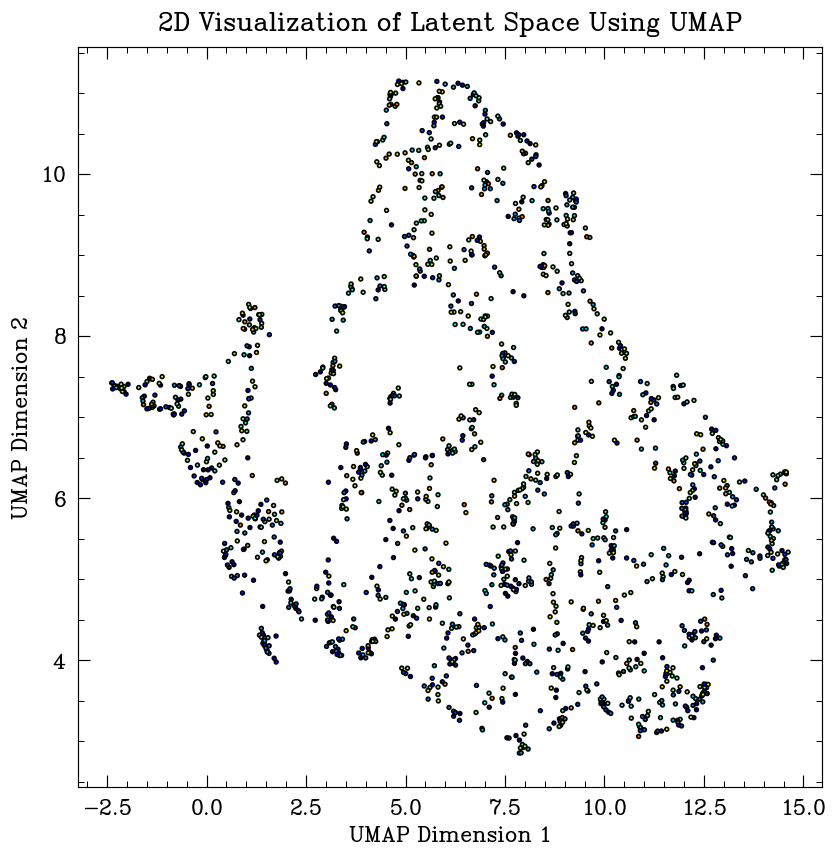

In [21]:
import umap.umap_ as umap
import smplotlib 

# Apply UMAP for 2D conversion
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
latent_space_2d = umap_model.fit_transform(latent_space)

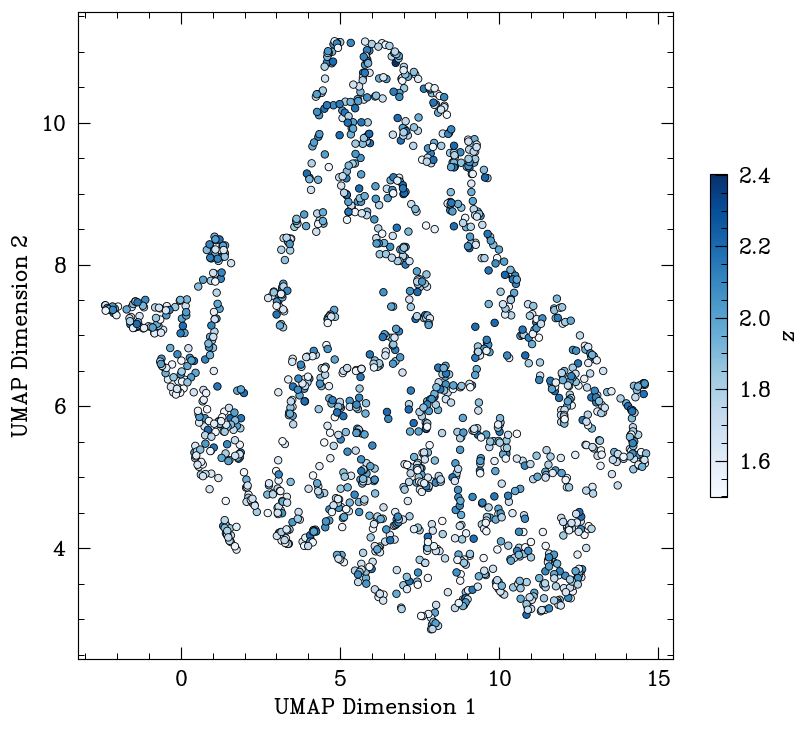

In [35]:
# Visualize the 2D projection
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 7))
scatter = plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=z_val, s=20, linewidth=.5, cmap="Blues")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

cbar = plt.colorbar(scatter, shrink=0.5)
cbar.set_label(r'$z$')  # Replace with your label

plt.savefig('umap.png', dpi=400)

In [34]:
i_fluxes = []
for name in name_val: 
    

['spec-7850-56956-0067.fits',
 'spec-7741-58078-0612.fits',
 'spec-7863-56975-0307.fits',
 'spec-7865-56955-0875.fits',
 'spec-11309-58428-0899.fits',
 'spec-7862-56984-0370.fits',
 'spec-7864-56979-0746.fits',
 'spec-7665-57328-0572.fits',
 'spec-7746-58074-0966.fits',
 'spec-7672-57339-0655.fits',
 'spec-7852-56987-0013.fits',
 'spec-11277-58450-0042.fits',
 'spec-4216-55477-0079.fits',
 'spec-7744-58396-0476.fits',
 'spec-7854-56989-0291.fits',
 'spec-7593-56958-0442.fits',
 'spec-6113-56219-0902.fits',
 'spec-4415-55831-0688.fits',
 'spec-7853-56988-0113.fits',
 'spec-7696-57655-0042.fits',
 'spec-11312-58433-0320.fits',
 'spec-11313-58426-0694.fits',
 'spec-8744-58124-0291.fits',
 'spec-6176-56264-0714.fits',
 'spec-11312-58433-0599.fits',
 'spec-11561-58485-0549.fits',
 'spec-9407-58041-0732.fits',
 'spec-7169-56628-0900.fits',
 'spec-7746-58074-0633.fits',
 'spec-7741-58078-0238.fits',
 'spec-11311-58429-0906.fits',
 'spec-7867-57003-0940.fits',
 'spec-7862-56984-0257.fits',
 's

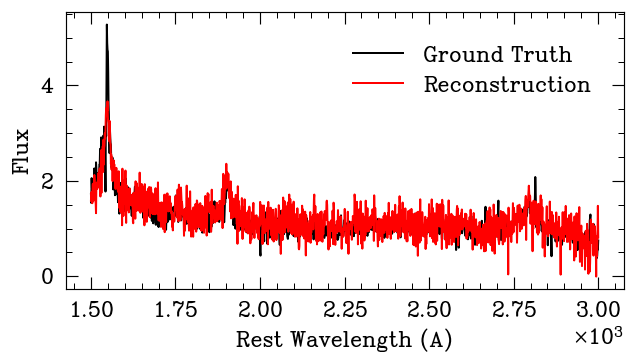

<Figure size 720x720 with 0 Axes>

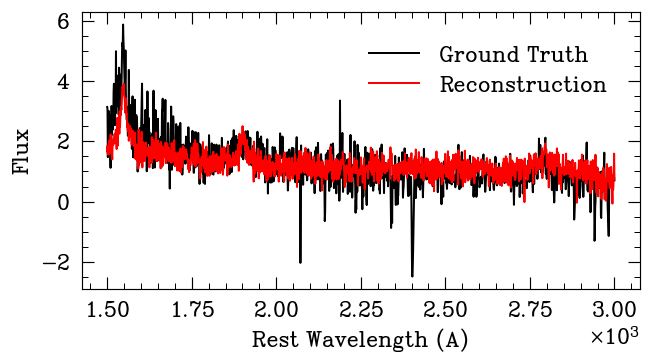

<Figure size 720x720 with 0 Axes>

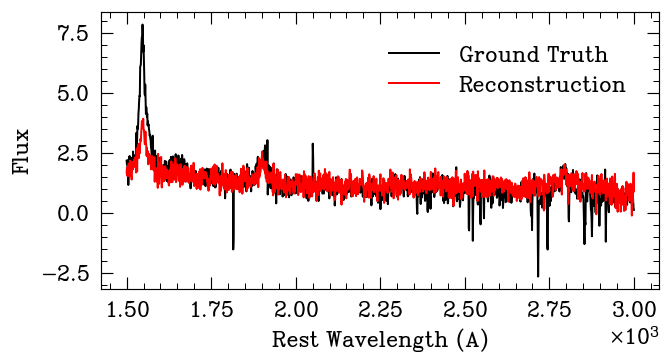

<Figure size 720x720 with 0 Axes>

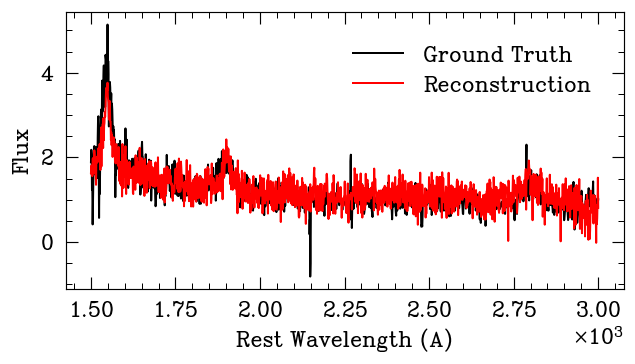

<Figure size 720x720 with 0 Axes>

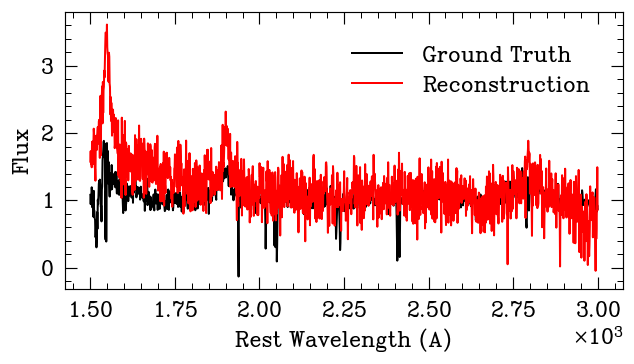

<Figure size 720x720 with 0 Axes>

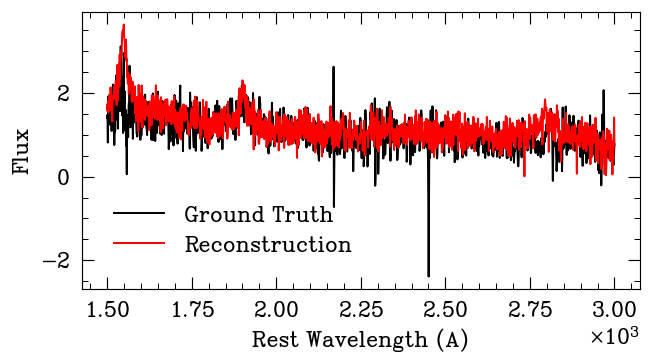

<Figure size 720x720 with 0 Axes>

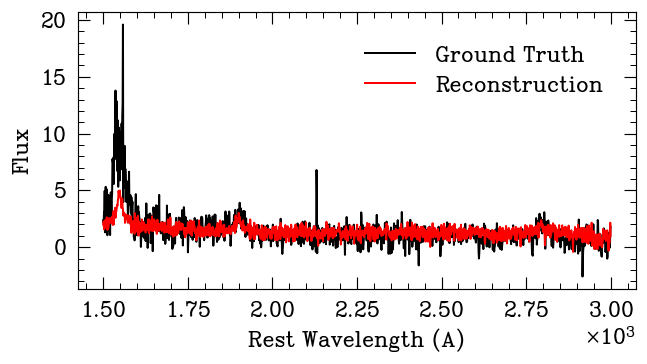

<Figure size 720x720 with 0 Axes>

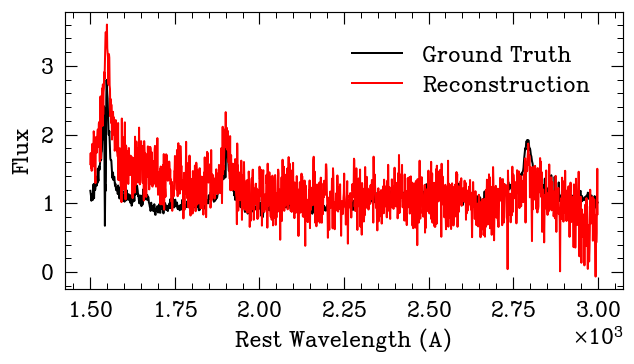

<Figure size 720x720 with 0 Axes>

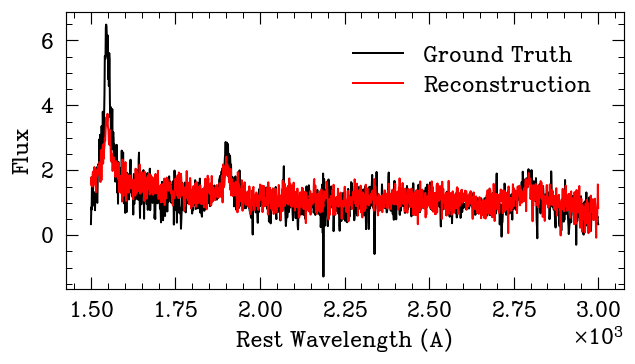

<Figure size 720x720 with 0 Axes>

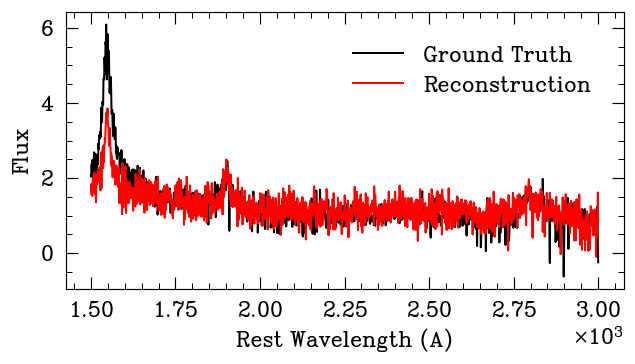

<Figure size 720x720 with 0 Axes>

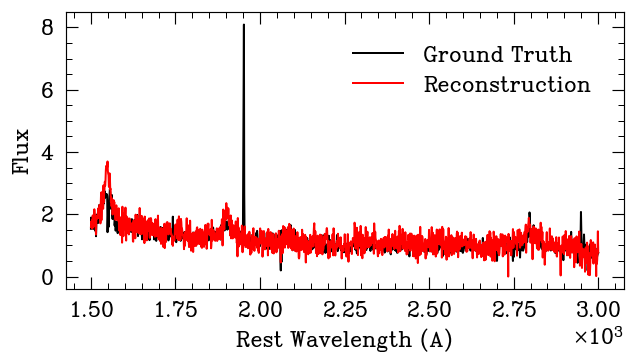

<Figure size 720x720 with 0 Axes>

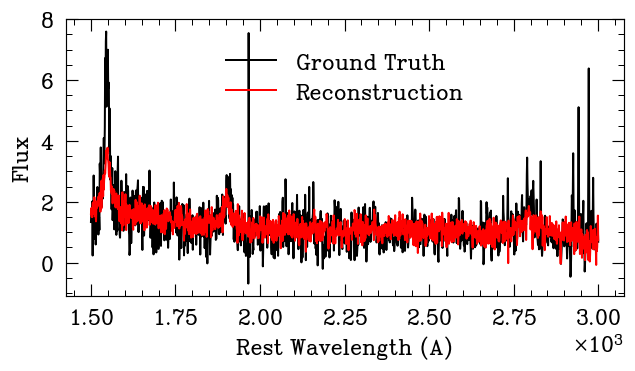

<Figure size 720x720 with 0 Axes>

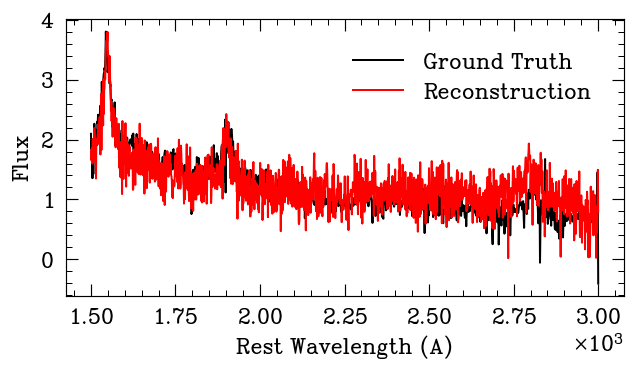

<Figure size 720x720 with 0 Axes>

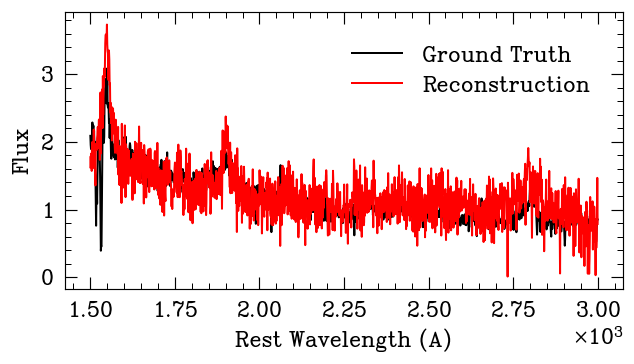

<Figure size 720x720 with 0 Axes>

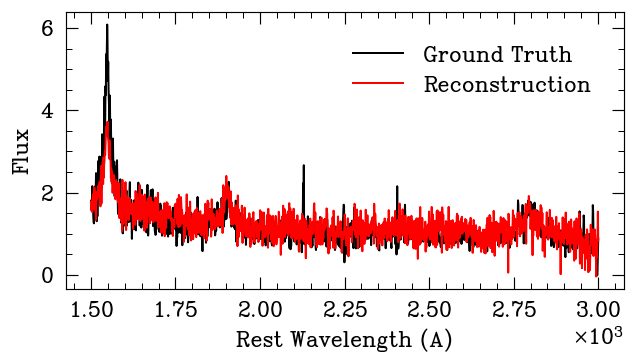

<Figure size 720x720 with 0 Axes>

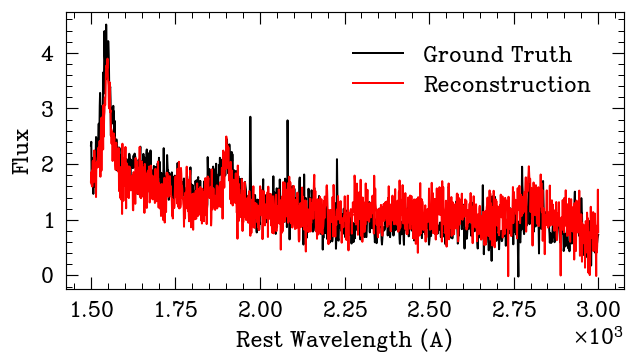

<Figure size 720x720 with 0 Axes>

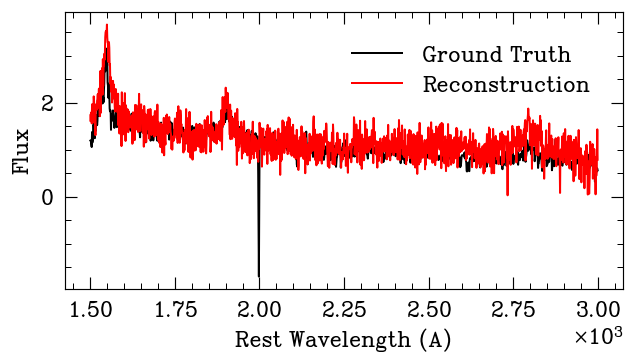

<Figure size 720x720 with 0 Axes>

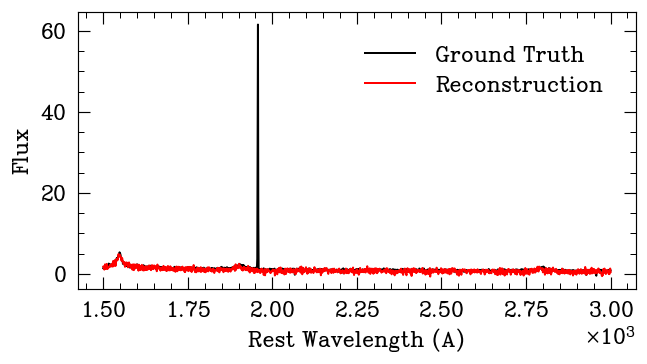

<Figure size 720x720 with 0 Axes>

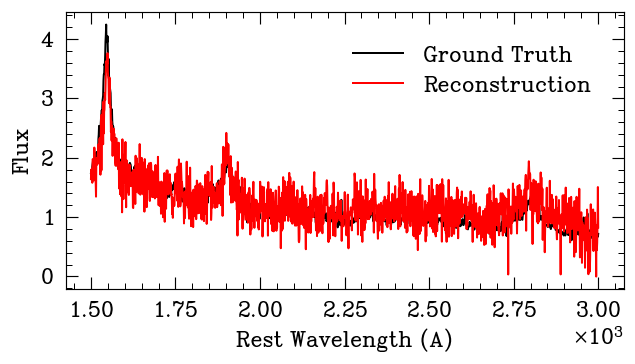

<Figure size 720x720 with 0 Axes>

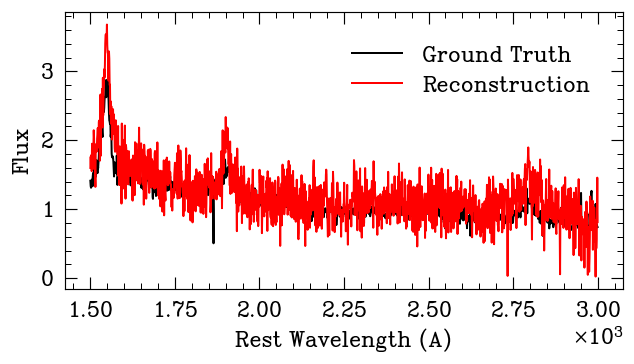

<Figure size 720x720 with 0 Axes>

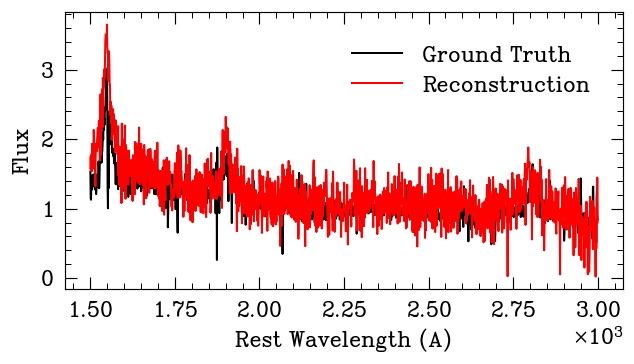

<Figure size 720x720 with 0 Axes>

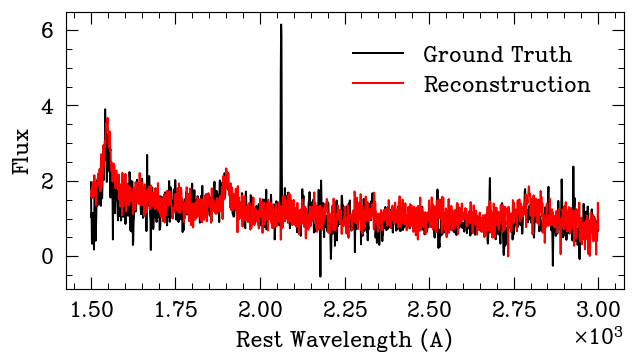

<Figure size 720x720 with 0 Axes>

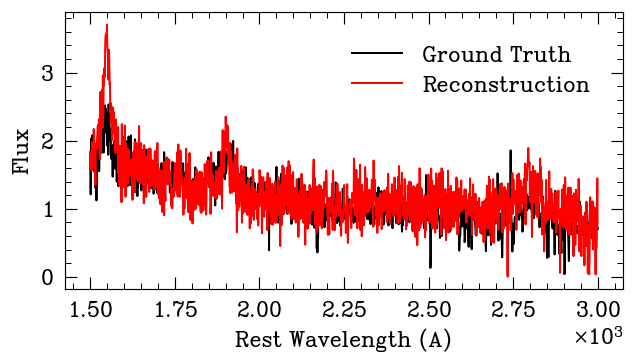

<Figure size 720x720 with 0 Axes>

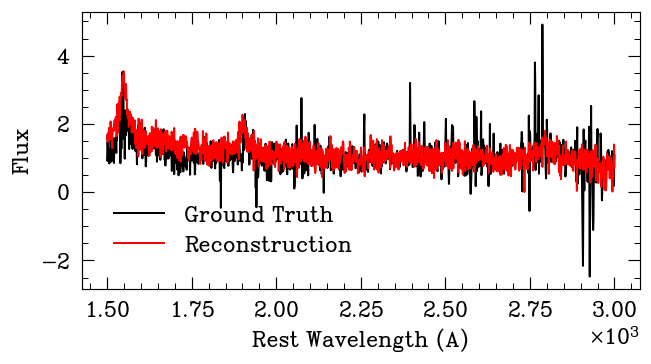

<Figure size 720x720 with 0 Axes>

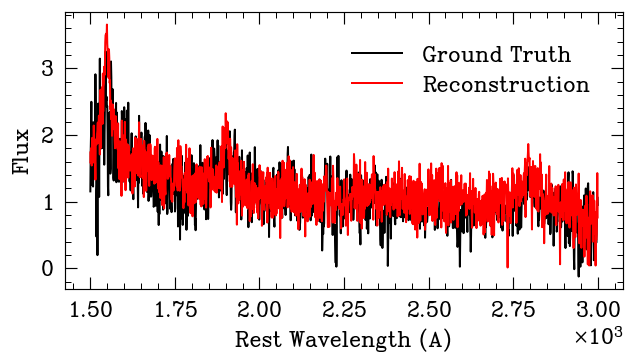

<Figure size 720x720 with 0 Axes>

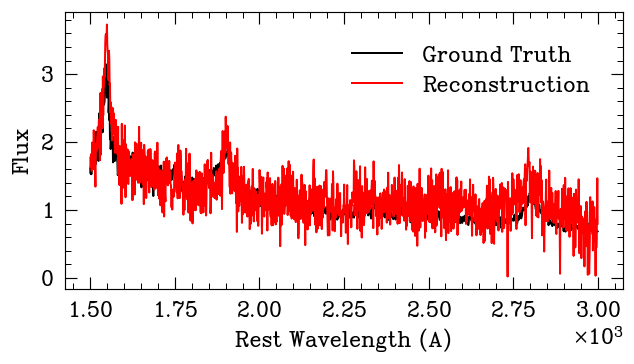

<Figure size 720x720 with 0 Axes>

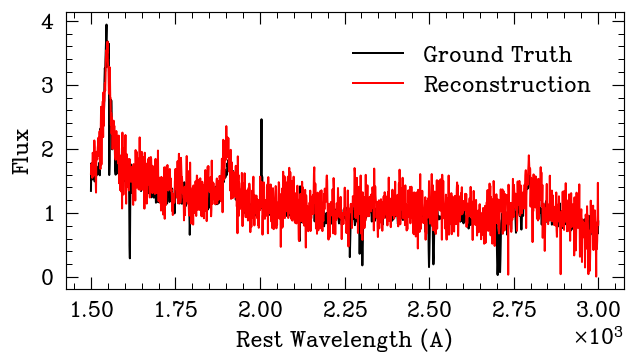

<Figure size 720x720 with 0 Axes>

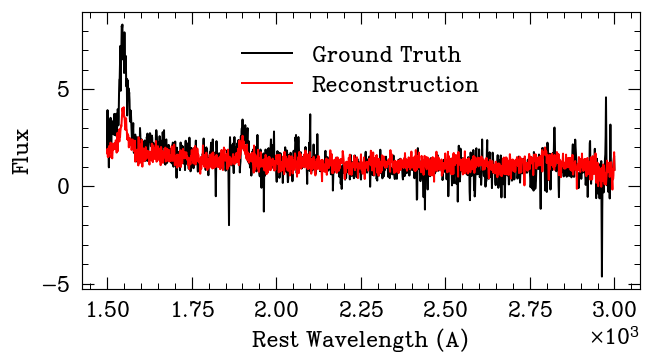

<Figure size 720x720 with 0 Axes>

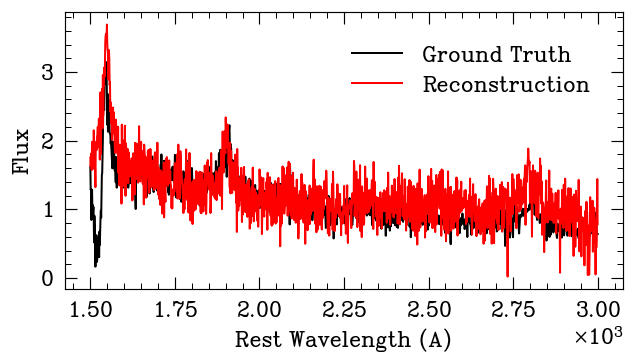

<Figure size 720x720 with 0 Axes>

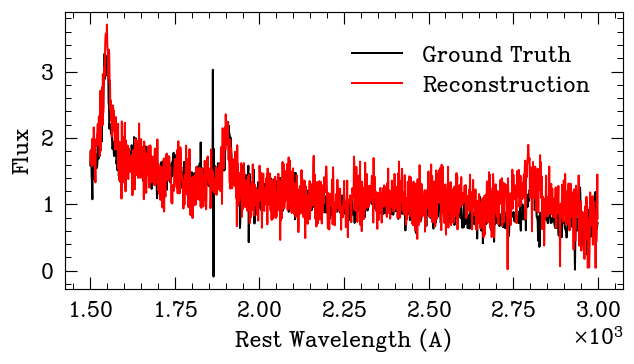

<Figure size 720x720 with 0 Axes>

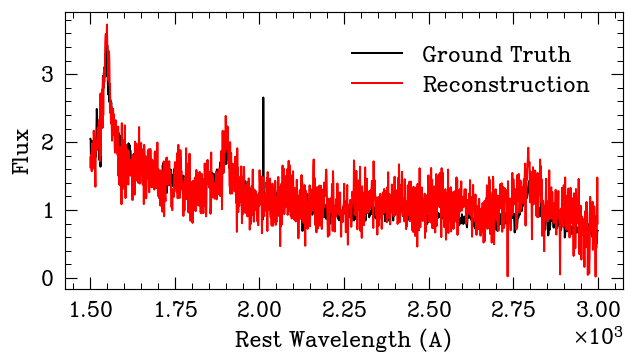

<Figure size 720x720 with 0 Axes>

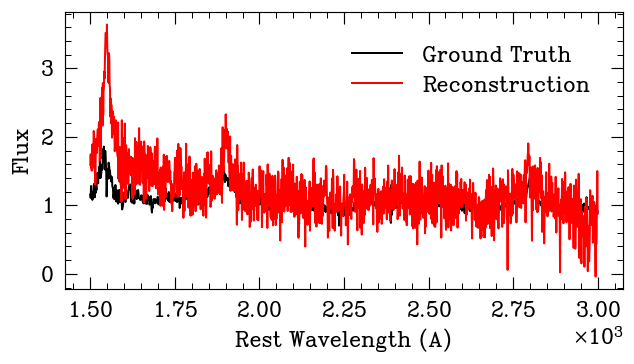

<Figure size 720x720 with 0 Axes>

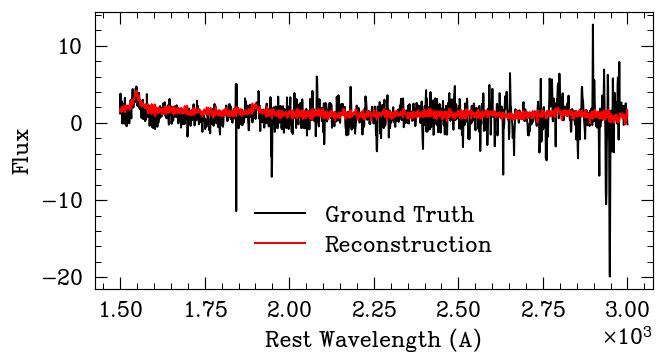

<Figure size 720x720 with 0 Axes>

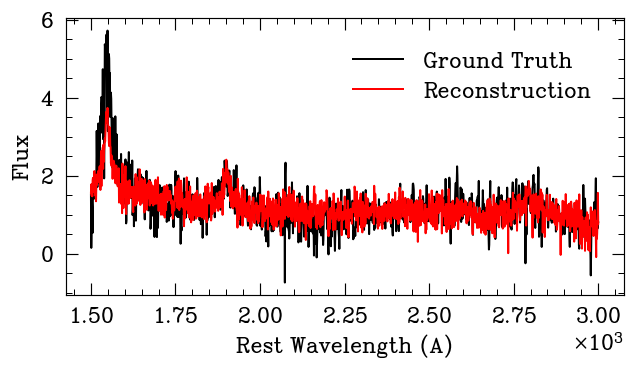

<Figure size 720x720 with 0 Axes>

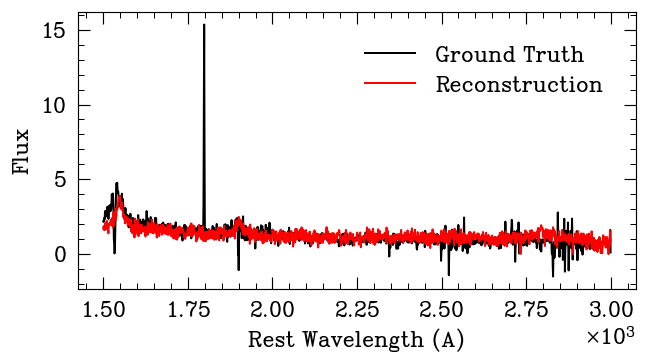

<Figure size 720x720 with 0 Axes>

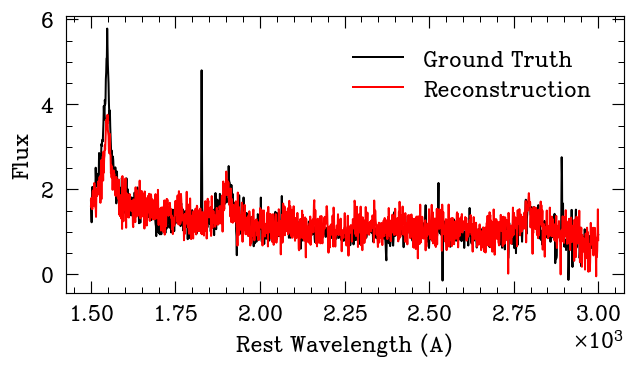

<Figure size 720x720 with 0 Axes>

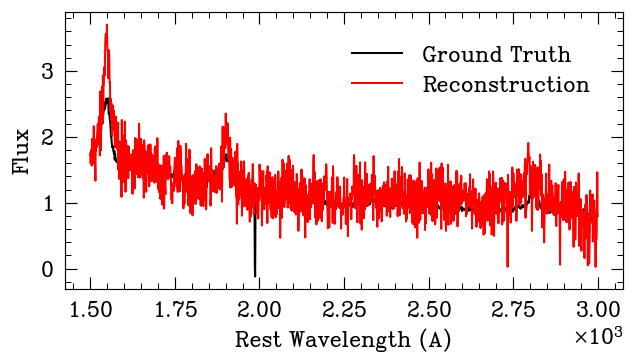

<Figure size 720x720 with 0 Axes>

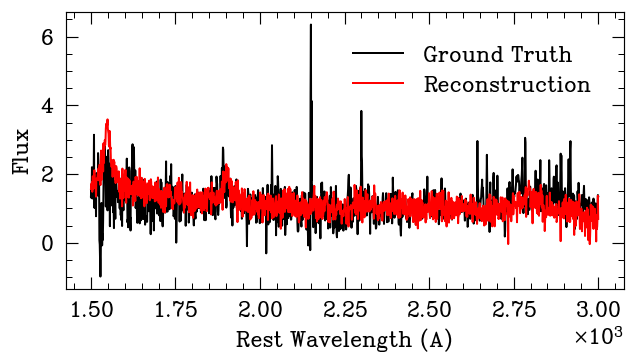

<Figure size 720x720 with 0 Axes>

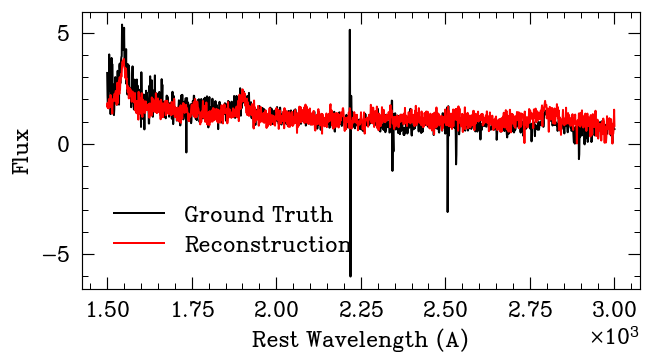

<Figure size 720x720 with 0 Axes>

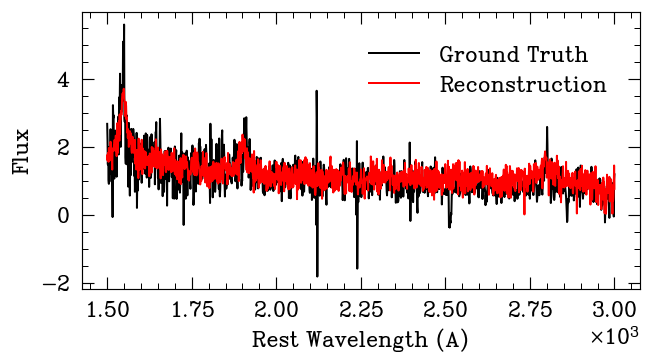

<Figure size 720x720 with 0 Axes>

In [12]:
import smplotlib

for i in range(40):

    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(x, X_val[i], color='black', label='Ground Truth')
    ax.plot(x, gaussian_filter1d(predictions[i], sigma=0.1), color='red', label='Reconstruction')

    ax.set(xlabel='Rest Wavelength (A)', ylabel='Flux')
    ax.legend(fontsize='medium')

    plt.show()
    plt.clf()